<a href="https://colab.research.google.com/github/gvigkannan/Model_ADay/blob/Keras/DR_ResNet9ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization as BN, MaxPool2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Activation, add

## Loading and Preprocessing


In [8]:
# Setting random seed for similar results
def set_random (seed_num=42):
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

set_random(seed_num = 42)

In [9]:
# Loading the Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Preprocessing:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)
def train_valid_split(X_data, y_data, split_ratio):
    """
    Given X_train & y_train, split shuffled data based on ratio
    """
    val_size = int(len(X_data) * 0.2)
    shuffled_indices = np.random.permutation(len(X_data))
    val_indices = shuffled_indices[:val_size]
    train_indices = shuffled_indices[val_size:]
    return (X_data[train_indices], y_data[train_indices]), (X_data[val_indices], y_data[val_indices])


# Splitting the dataset into train and validation
(X_train, y_train), (X_val, y_val) = train_valid_split(X_data = X_train,
                                                   y_data = y_train,
                                                   split_ratio = 0.2)

## Model Configuration and Definition


In [12]:
# Model Configuration :
batch_size = 32
img_width, img_ht, img_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
n_classes = 10
n_epochs = 50 #20
optimizer = Adamax()
validation_split = 0.2
verbosity = 1

In [13]:
input_shape = X_train.shape[-3:]

In [14]:
def conv_block(layer_in, filter_size):
    conv = Conv2D(filter_size, 
                   kernel_size = (3,3),
                   padding = 'same',
                   kernel_initializer = 'he_normal')(layer_in)
    conv = BN()(conv)
    conv = Activation('relu')(conv)
    return conv

In [15]:
def residual_block(layer_in, n_filters):
    """
    Residual Block
    """

    merge_input = layer_in
    # In case, the number of filters increases - assuming the channel is the last number in shape
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(filters = n_filters, 
                             kernel_size = (1,1), 
                             padding = 'same',
                             kernel_initializer = 'he_normal')(merge_input)
    # Conv_x_1
    conv_1 = Conv2D(filters = n_filters,
                    kernel_size = (3,3),
                    padding = 'same',
                    kernel_initializer = 'he_normal')(layer_in)
    conv_1 = BN()(conv_1)
    conv_1 = Activation('relu')(conv_1)
    # Conv_x_2
    conv_2 = Conv2D(filters = n_filters,
                    kernel_size = (3,3),
                    padding = 'same',
                    kernel_initializer = 'he_normal')(conv_1)

    layer_out = add([conv_2, merge_input])
    layer_out = BN()(layer_out)
    layer_out = Activation('relu')(layer_out)

    return layer_out

### Baseline - ResNet9


In [16]:
input_shape

(32, 32, 3)

In [17]:
def ResNet9(conv_filters, layer_in):
    layer_input = layer_in
    # Conv_1
    conv_1 = Conv2D(filters = conv_filters[0],
                    kernel_size = (3,3),
                    padding = 'same',
                    kernel_initializer = 'he_normal')(layer_input)

    conv_1 = BN()(conv_1)
    conv_1 = Activation('relu')(conv_1)
    maxpool_1 = MaxPool2D(strides = (2,2))(conv_1)

    # Conv_2
    conv_2 = residual_block(layer_in = conv_1, 
                            n_filters = conv_filters[1])
    maxpool_2 = MaxPool2D(strides = (2,2))(conv_2)

    # Conv_3 
    conv_3 = Conv2D(filters = conv_filters[2],
                    kernel_size = (3,3),
                    padding = 'same',
                    kernel_initializer = 'he_normal')(maxpool_2)

    conv_3 = BN()(conv_3)
    conv_3 = Activation('relu')(conv_3)
    maxpool_3 = MaxPool2D(strides = (2,2))(conv_3)

    # Flatten
    flat_conv =  Flatten()(maxpool_3)
    dense_1 = Dense(128, kernel_initializer = 'he_uniform', activation = 'relu')(flat_conv)
    dense_1 = Dropout(0.4)(dense_1)
    dense_output = Dense(10, activation = 'softmax')(dense_1)    
    return Model(layer_in, dense_output)


In [18]:
conv_filters = [32, 64, 128]
visible = Input(shape = input_shape)
model_resnet9 = ResNet9(conv_filters, visible)
model_resnet9.summary()
#plot_model(model_baseline, show_shapes = True, to_file = 'CNN_Baseline.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

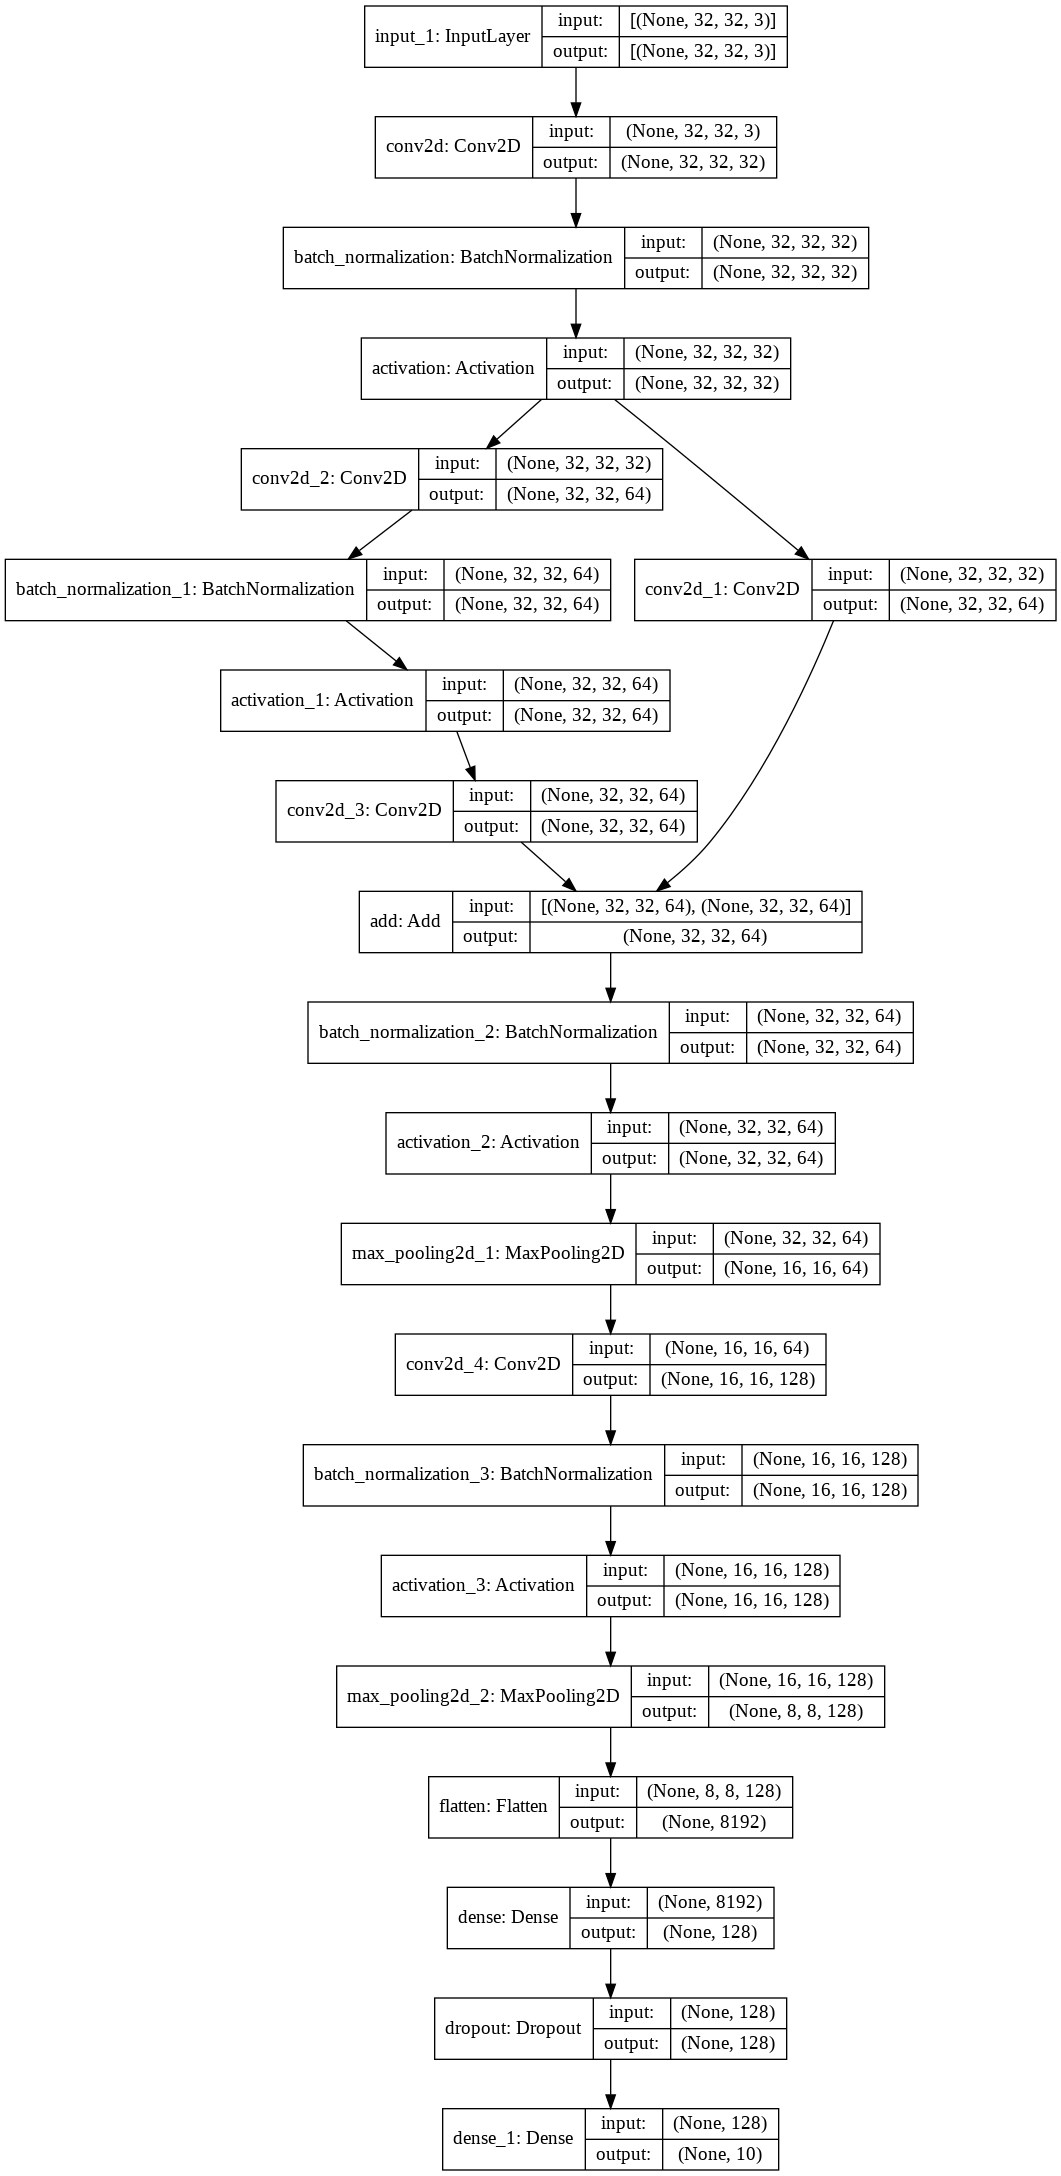

In [19]:
plot_model(model_resnet9, show_shapes = True, to_file = 'ResNet_9_Final.png')

## Training


In [23]:
model_resnet9.compile(optimizer = optimizer, 
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])


In [24]:
file_name = "model_resnet9-{epoch:02d}-{val_accuracy:.4f}_v2.h5"
my_callbacks = [keras.callbacks.CSVLogger('model_resnet9_Log_v2.csv', 
                                          append = True),
                keras.callbacks.ModelCheckpoint(filepath = file_name,
                                                save_weights_only = True,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                save_best_only = True,
                                                verbose = verbosity)]
 # Implement LR Peak as described by Slyvian Plath - fast.ai 


In [25]:
history_resnet9 = []
history_resnet9 = model_resnet9.fit(x = X_train, y = y_train,
                            batch_size = batch_size,
                            epochs = 1,
                            validation_data = (X_val, y_val),
                            callbacks = my_callbacks,
                            verbose = verbosity)

1250/1250 [==============================] - 11s 8ms/step - loss: 1.7970 - accuracy: 0.3174 - val_loss: 1.3802 - val_accuracy: 0.4882

Epoch 00001: val_accuracy improved from -inf to 0.48820, saving model to model_resnet9-01-0.4882_v2.h5


In [26]:
history_resnet9 = model_resnet9.fit(x = X_train, y = y_train,
                            batch_size = batch_size,
                            epochs = n_epochs,
                            validation_data = (X_val, y_val),
                            callbacks = my_callbacks,
                            verbose = verbosity)

Epoch 1/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5650 - accuracy: 0.3971 - val_loss: 1.2736 - val_accuracy: 0.5639

Epoch 00001: val_accuracy improved from 0.48820 to 0.56390, saving model to model_resnet9-01-0.5639_v2.h5
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4809 - accuracy: 0.4315 - val_loss: 1.2524 - val_accuracy: 0.5567

Epoch 00002: val_accuracy did not improve from 0.56390
Epoch 3/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4238 - accuracy: 0.4460 - val_loss: 1.0908 - val_accuracy: 0.6172

Epoch 00003: val_accuracy improved from 0.56390 to 0.61720, saving model to model_resnet9-03-0.6172_v2.h5
Epoch 4/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.3659 - accuracy: 0.4718 - val_loss: 1.0774 - val_accuracy: 0.6294

Epoch 00004: val_accuracy improved from 0.61720 to 0.62940, saving model to model_resnet9-04-0.6294_v2.h5
Epoch 5/50
1250/1250 [=====================

TypeError: ignored

In [ ]:
model_baseline.save("ResNet9_v1.h5")